In [277]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import confusion_matrix
import statsmodels.formula.api as smf
#Pentru normalitate
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import shapiro 
from scipy.stats import kstest, norm
#Pentru Homoschedasticitate
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
#Pentru multicolinaritate si autocorelare
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
#Pentru autocorelare si specificare
from statsmodels.stats.diagnostic import linear_reset
#Pentru calcul metrici
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
#Clusteri
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
#Lasso Ridge Elastic Net
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

In [118]:
def testare_homoschedasticitate(regression,actual,afiseaza_grafic=True):
    residuals = regression.resid
    exog = regression.model.exog
    print("Testul White")
    white_t = het_white(residuals,exog)
    print(white_t)
    print("Test Breuche-Pagan")
    bpt = het_breuschpagan(residuals,exog)
    print(bpt)
    if afiseaza_grafic is True:
        plt.figure(figsize=(10,8))
        plt.scatter(actual,residuals)
        plt.xlabel("Valori reale")
        plt.ylabel("Valori estimate")
        plt.title("Real vs Estimat")
        plt.show()

In [119]:
def testare_normalitate(regresie,bins,afiseaza_grafic=True):
    #Testare normalitate
    reziduuri = regresie.resid
    jb = jarque_bera(reziduuri)
    print("jarque_bera")
    print(jb)
    print("SHAPIRO")
    shapiro_test = shapiro(reziduuri)
    print(shapiro_test)
    print("Kolmogov Smirnov")
    print(kstest(reziduuri, "norm", args=(reziduuri.mean(), reziduuri.std())))
    if afiseaza_grafic is True:
        plt.figure(figsize=(10,6))
        plt.title("Distributia erorilor")
        plt.hist(reziduuri,bins=bins)
        plt.show()

In [120]:
df =  pd.read_csv("World-happiness-report-2024.csv",index_col="Country name")

In [121]:
df.head()

,Regional indicator,Ladder score,upperwhisker,lowerwhisker,Log GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Dystopia + residual
Country name,,,,,,,,,,,
Finland,Western Europe,7.741,7.815,7.667,1.844,1.572,0.695,0.859,0.142,0.546,2.082
Denmark,Western Europe,7.583,7.665,7.500,1.908,1.520,0.699,0.823,0.204,0.548,1.881
Iceland,Western Europe,7.525,7.618,7.433,1.881,1.617,0.718,0.819,0.258,0.182,2.050
Sweden,Western Europe,7.344,7.422,7.267,1.878,1.501,0.724,0.838,0.221,0.524,1.658
Israel,Middle East and North Africa,7.341,7.405,7.277,1.803,1.513,0.740,0.641,0.153,0.193,2.298


In [122]:
# Verifca statele care au missing values pe oricare coloana
df[df.isna().any(axis=1) == True]

,Regional indicator,Ladder score,upperwhisker,lowerwhisker,Log GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Dystopia + residual
Country name,,,,,,,,,,,
Bahrain,Middle East and North Africa,5.959,6.153,5.766,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tajikistan,Commonwealth of Independent States,5.281,5.361,5.201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
State of Palestine,Middle East and North Africa,4.879,5.006,4.753,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
df.dropna(inplace=True)

In [124]:
# print(df['Regional indicator'].drop_duplicates())
Asia = ['Southeast Asia','East Asia','South Asia']
Europe = ['Western Europe','Central and Eastern Europe']
North_America = ['United States','Canada']
Australia = ['Australia','New Zealand']
Africa = ['Sub-Saharan Africa']
Countries_not_in_middle_east =['Ukraine','Moldova','Georgia']
African_countries = ["Libya","Algeria","Morocco","Tunisia","Egypt"]

In [125]:
# print(Asia)
# print(Europe)
# print(North_America)
# print(Australia)
# print(Africa)
# print(Countries_not_in_middle_east)
# print(African_countries)

In [126]:
df.rename(columns={
    'Log GDP per capita':'GDP_capita_logged',
    'Perceptions of corruption':'Coruption',
    'Healthy life expectancy':'Life_expectancy',
    'Social support':'Social_support',
    'Ladder score':'happy',
    'Regional indicator':'Region',
    'Freedom to make life choices':'Freedom'
},inplace=True)

In [127]:
df['Region_2'] = df.apply(lambda x: 'Asia' if x['Region'] in Asia else
                                              'Europe' if x['Region'] in Europe else
                                              'North_America' if x.name in North_America else
                                              'Australia' if x.name in Australia else
                                              'Africa' if x['Region'] in Africa else
                                              'South_America' if x['Region'] =='Latin America and Caribbean' else
                                              'Europe' if x['Region']=='Commonwealth of Independent States' and x.name in Countries_not_in_middle_east else
                                              'Middle_East' if x['Region']=='Commonwealth of Independent States' and x.name not in Countries_not_in_middle_east else
                                              'Africa' if x.name in African_countries else 'Middle East',axis=1)

In [128]:
df.loc[df['Region_2']=='Middle East','Region_2'] = 'Middle_East'
continents = df['Region_2'].drop_duplicates()
for continent in continents:
    conditie = df['Region_2'] == continent
    # print(sum(conditie))
    df[continent] = 0
    df.loc[conditie,continent] = 1

In [129]:
df['Social_support']

Country name
Finland             1.572
Denmark             1.520
Iceland             1.617
Sweden              1.501
Israel              1.513
                    ...  
Congo (Kinshasa)    0.665
Sierra Leone        0.566
Lesotho             0.851
Lebanon             0.577
Afghanistan         0.000
Name: Social_support, Length: 140, dtype: float64

In [130]:

# centroizi_total = []
# nrClustere = range(1,6)
# for var in variabile:
#     # print(var)
#     X = df[[var]].values
#     centroizi_var = []
#     for n in nrClustere:
#         kmeans = KMeans(n_clusters=n,
#                         random_state=42,
#                         n_init=10)
#         kmeans.fit(X)
#         # print(kmeans.inertia_)
#         centroizi_var.append(kmeans.inertia_)
#     centroizi_total.append(centroizi_var)

In [131]:
# fig, axes = plt.subplots(2, 3, figsize=(15, 8))
# axes = axes.flatten()

# k_values = range(1, len(centroizi_total[0]) + 1)

# for i, ax in enumerate(axes):
#     ax.plot(k_values, centroizi_total[i], marker='o')
#     ax.set_title(f'Elbow Plot – {variabile[i]}')
#     ax.set_xlabel('Number of clusters (k)')
#     ax.set_ylabel('Elbow value')

# plt.tight_layout()
# plt.show()

In [132]:
# centroizi_total

d:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

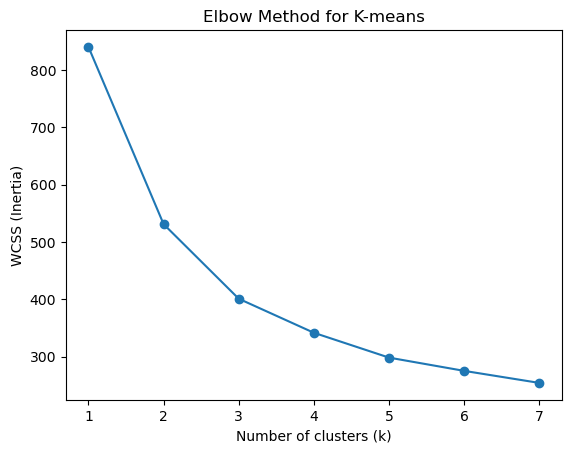

In [133]:
variabile = ['GDP_capita_logged','Social_support', 'Life_expectancy', 'Freedom', 'Generosity','Coruption']
X = df[variabile].values
X_scaled = StandardScaler().fit_transform(X)
inertias = []

for k in range(1, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(range(1, 8), inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method for K-means")
plt.show()

Mergem pe 2 clustere

### Spargere in train_test stratificat

In [224]:
df['cluster'] = KMeans(n_clusters=2,random_state=42,n_init=10).fit_predict(X_scaled)
print(df['cluster'].value_counts(normalize=True))
df_train = df.groupby('cluster').sample(frac=0.8)
index_train = df_train.index
conditie = ~df.index.isin(index_train)
df_test = df[conditie].copy()
print(len(df_test['cluster'].value_counts(normalize=True)))
print(len(df_train['cluster'].value_counts(normalize=True)))

d:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


cluster
1    0.635714
0    0.364286
Name: proportion, dtype: float64
2
2


### Inceput Regresie

In [225]:
regresie = smf.ols('happy ~ GDP_capita_logged + Social_support + Freedom + South_America',data=df_train).fit()
print(regresie.summary()) 
exog = regresie.model.exog
fit = regresie.fittedvalues


                            OLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     94.57
Date:                Tue, 23 Dec 2025   Prob (F-statistic):           3.17e-34
Time:                        17:00:46   Log-Likelihood:                -87.073
No. Observations:                 112   AIC:                             184.1
Df Residuals:                     107   BIC:                             197.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.2687      0.23

Testul White
(16.933481207906198, 0.20236280548475408, 1.342769235899256, 0.20193579769668138)
Test Breuche-Pagan
(11.891263943957847, 0.018178439986695116, 3.1774580624292437, 0.016476926735773022)


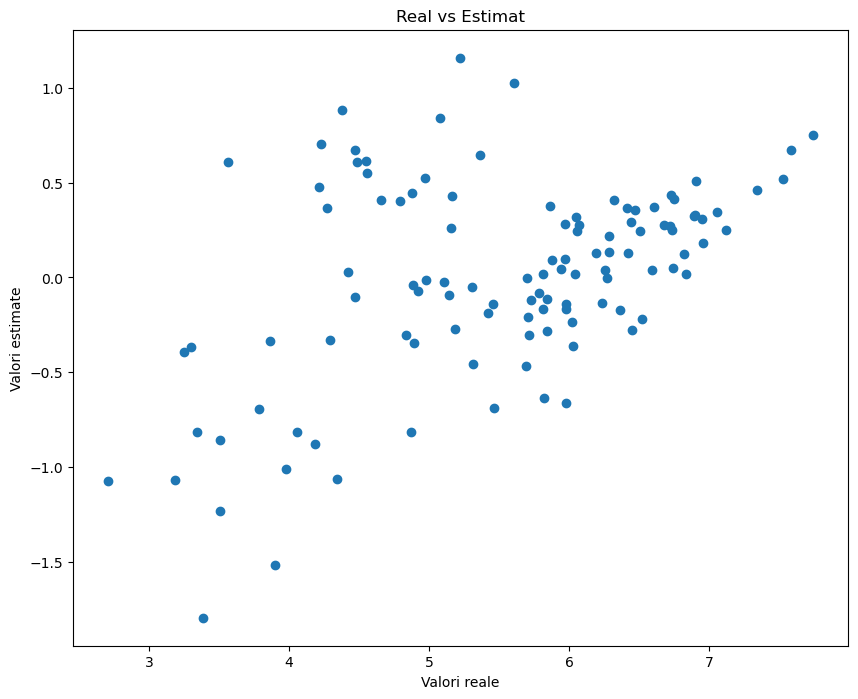

In [226]:
testare_homoschedasticitate(regresie,df_train.loc[df_train.index,'happy'])

In [227]:
weigths = 1 / (np.power(fit,2))
wls = sm.WLS(df_train.loc[df_train.dropna().index,'happy'],exog=exog,weights=weigths).fit()
print(wls.summary())

                            WLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.751
Model:                            WLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     80.68
Date:                Tue, 23 Dec 2025   Prob (F-statistic):           2.05e-31
Time:                        17:00:48   Log-Likelihood:                -101.02
No. Observations:                 112   AIC:                             212.0
Df Residuals:                     107   BIC:                             225.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5874      0.218      7.284      0.0

Testul White
(17.06395882114628, 0.19639672145324813, 1.3549753673081897, 0.1954667004952104)
Test Breuche-Pagan
(7.346294499819502, 0.11868118771491909, 1.877748875980629, 0.1196199986350434)


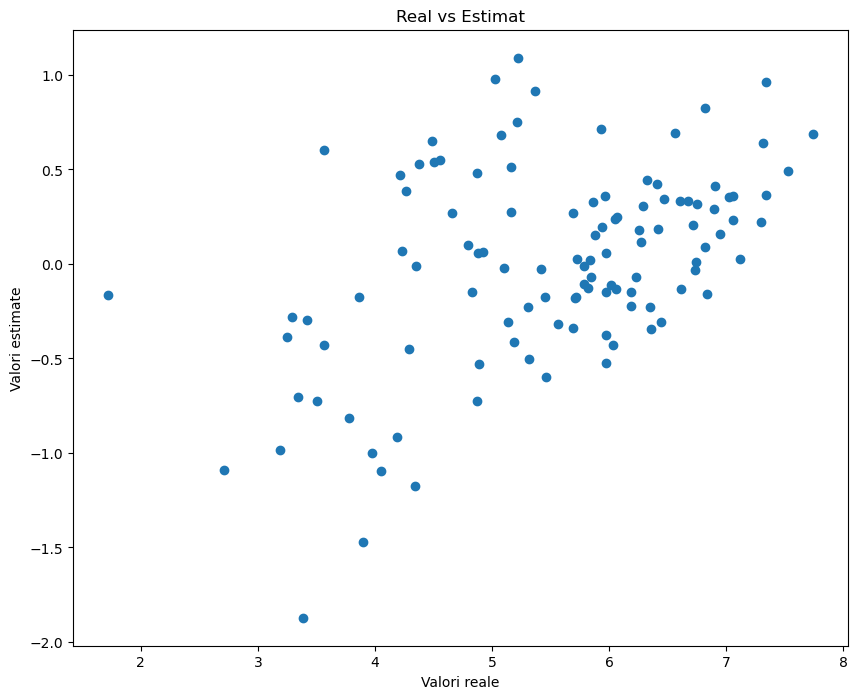

In [182]:
testare_homoschedasticitate(wls,df_train.loc[df_train.index,'happy'])

In [183]:
model_corectat = regresie.get_robustcov_results(cov_type='HC3')
print(model_corectat.summary())

                            OLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     122.0
Date:                Tue, 23 Dec 2025   Prob (F-statistic):           6.21e-39
Time:                        16:18:32   Log-Likelihood:                -85.634
No. Observations:                 112   AIC:                             181.3
Df Residuals:                     107   BIC:                             194.9
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.0280      0.24

=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.0280      0.225      4.573      0.000       0.582       1.474
GDP_capita_logged     1.3375      0.206      6.489      0.000       0.929       1.746
Social_support        0.9850      0.254      3.884      0.000       0.482       1.488
Freedom               2.3623      0.378      6.248      0.000       1.613       3.112
South_America         0.3395      0.158      2.151      0.034       0.027       0.652

Testul White
(17.341383583201416, 0.1841642286212988, 1.3810401853969276, 0.18221863540699887)
Test Breuche-Pagan
(8.45940695223408, 0.07612725764043168, 2.18551129862535, 0.07546778453533025)


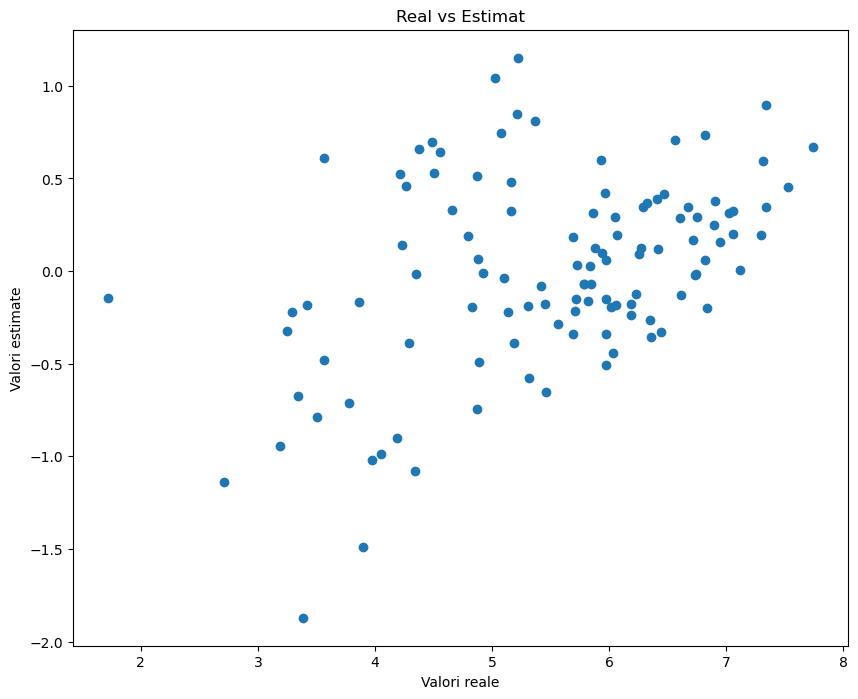

In [184]:
testare_homoschedasticitate(model_corectat,df_train.loc[df_train.index,'happy'])

jarque_bera
(14.012872622602803, 0.0009060316567546736, -0.7630618605315397, 3.820795228505717)
SHAPIRO
ShapiroResult(statistic=0.962568998336792, pvalue=0.0031620333902537823)
Kolmogov Smirnov
KstestResult(statistic=0.08117642396742109, pvalue=0.4289970285366288, statistic_location=0.24645003426422996, statistic_sign=-1)


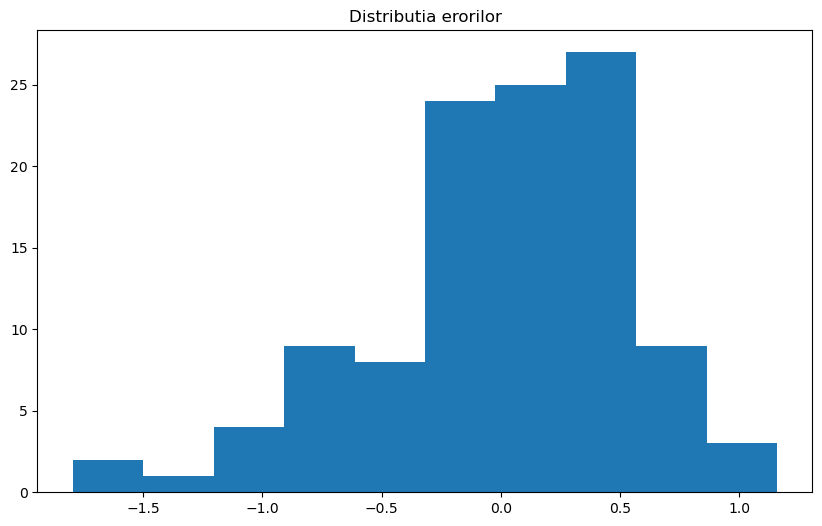

In [228]:
#Testare normalitate
testare_normalitate(regresie=regresie,bins=10)

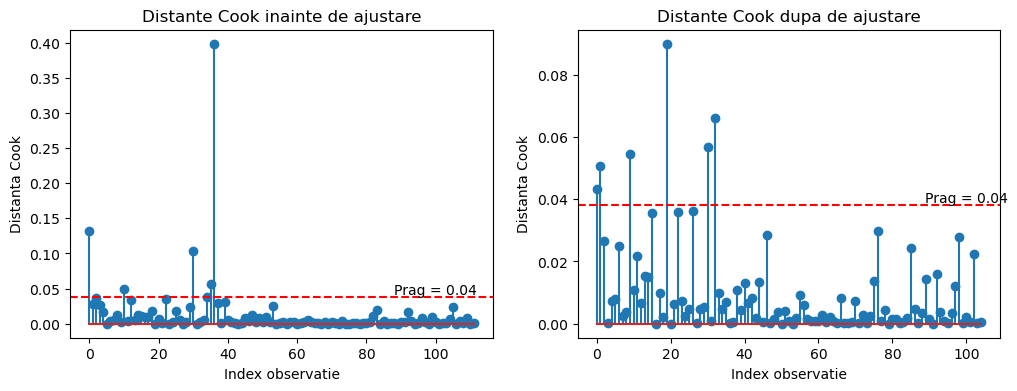

jarque_bera
(8.911537949631265, 0.011611387576094229, -0.6259733710809607, 3.6852388741934226)
SHAPIRO
ShapiroResult(statistic=0.9736087918281555, pvalue=0.0341426357626915)
Kolmogov Smirnov
KstestResult(statistic=0.06607608441469642, pvalue=0.7236081449946359, statistic_location=-0.23175172135803468, statistic_sign=-1)


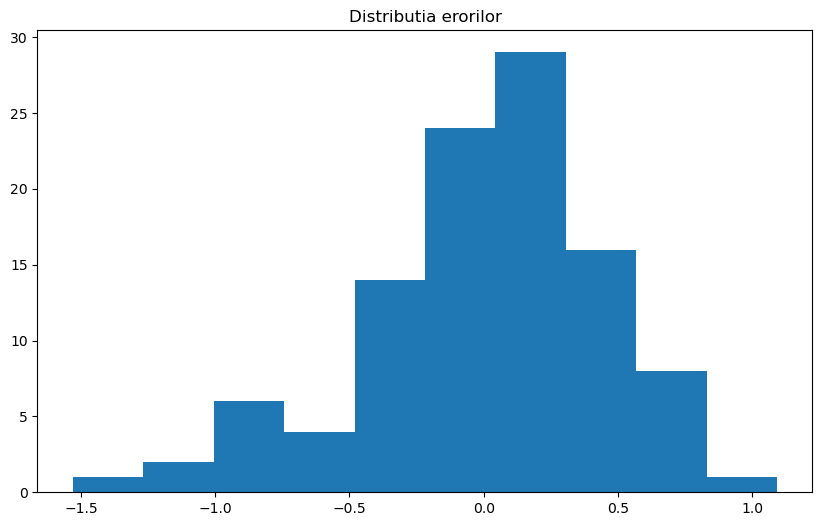

In [229]:
influence = regresie.get_influence()
cooks_d, p_values = influence.cooks_distance
df_with_cook = df_train.copy()
df_with_cook['cooks_d'] = cooks_d
influential = df_with_cook[df_with_cook['cooks_d'] > 4 / len(df_with_cook)]
df_with_cook.drop(index=influential.index,inplace=True)

figura, axe = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax1,ax2 = axe

ax1.stem(cooks_d)
ax1.set_xlabel('Index observatie')
ax1.set_ylabel("Distanta Cook")
ax1.set_title("Distante Cook inainte de ajustare")
ax1.axhline(4 / len(df_with_cook),linestyle="--",color='red')
ax1.text(100,
         4 / len(df_with_cook),
        f"Prag = {np.round(4 / len(df_with_cook),2)}",
        va="bottom",
        ha="center"
        )
regresie_cook = smf.ols('happy ~ GDP_capita_logged + Social_support + Freedom + South_America',data=df_with_cook).fit()
exog = regresie.model.exog
fit = regresie.fittedvalues


influence = regresie_cook.get_influence()
cooks_d, p_values = influence.cooks_distance
# df_with_cook = df.copy()
df_with_cook['cooks_d'] = cooks_d
influential = df_with_cook[df_with_cook['cooks_d'] > 4 / len(df_with_cook)]
# df_with_cook.drop(index=influential.index,inplace=True)
ax2.stem(cooks_d)
ax2.set_xlabel('Index observatie')
ax2.set_ylabel("Distanta Cook")
ax2.set_title("Distante Cook dupa de ajustare")
ax2.axhline(4 / len(df_with_cook),linestyle="--",color="red")
ax2.text(100,
         4 / len(df_with_cook),
        f"Prag = {np.round(4 / len(df_with_cook),2)}",
        va="bottom",
        ha="center"
        )
plt.show()

testare_normalitate(regresie=regresie_cook,bins=10)

In [149]:

# influence = regresie_cook.get_influence()
# cooks_d, p_values = influence.cooks_distance
# # df_with_cook = df.copy()
# df_with_cook['cooks_d'] = cooks_d
# influential = df_with_cook[df_with_cook['cooks_d'] > 4 / len(df_with_cook)]
# df_with_cook.drop(index=influential.index,inplace=True)
# plt.stem(cooks_d)
# plt.xlabel('Observation')
# plt.ylabel("Cook's Distance")
# plt.show()


In [230]:
regresie_cook = smf.ols('happy ~ GDP_capita_logged + Freedom + Social_support + South_America',data=df_with_cook).fit()
print(regresie_cook.summary())
exog = regresie_cook.model.exog
fit = regresie_cook.fittedvalues
weigths = 1 / (np.power(fit,2))
# wls = sm.WLS(df.loc[df.dropna().index,'happy'],exog=exog,weights=weigths).fit()

                            OLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     112.1
Date:                Tue, 23 Dec 2025   Prob (F-statistic):           4.62e-36
Time:                        17:02:23   Log-Likelihood:                -65.167
No. Observations:                 105   AIC:                             140.3
Df Residuals:                     100   BIC:                             153.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.2484      0.22

In [231]:
testare_homoschedasticitate(regresie_cook,df_with_cook.loc[df_with_cook.index,'happy'],afiseaza_grafic=False)

Testul White
(14.98912128003836, 0.30803240298343487, 1.1656796428652092, 0.3173185828343574)
Test Breuche-Pagan
(11.949170589282362, 0.017733275640437116, 3.210387984974278, 0.015921312495090496)


In [232]:
testare_normalitate(regresie_cook,bins=10,afiseaza_grafic=False)

jarque_bera
(8.911537949631377, 0.011611387576093576, -0.625973371080965, 3.6852388741934257)
SHAPIRO
ShapiroResult(statistic=0.9736087918281555, pvalue=0.0341426357626915)
Kolmogov Smirnov
KstestResult(statistic=0.06607608441469603, pvalue=0.7236081449946428, statistic_location=-0.23175172135803113, statistic_sign=-1)


Verificare Multicoloniaritate + Matrice de corelatii

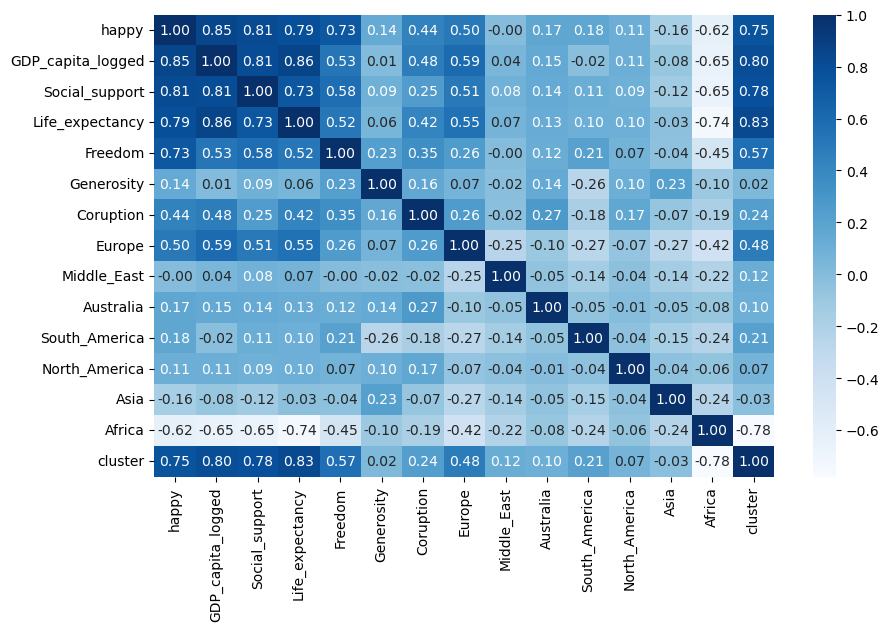

In [194]:
col = list(df_with_cook.drop(columns=["Region_2","cooks_d","upperwhisker","lowerwhisker","Dystopia + residual"],inplace=False).columns)[1:]
corel_matrix = df_with_cook[col].corr()

plt.figure(figsize=(10,6))
sns.heatmap(data=corel_matrix,fmt=".2f",cmap="Blues",annot=True)
plt.show()

In [154]:
vif = {k:variance_inflation_factor(exog,i) for k,i in zip(regresie_cook.params.index,range(len(regresie_cook.params.index)))}
vif

{'Intercept': 24.513197814644766,
 'GDP_capita_logged': 3.2302013417524176,
 'Freedom': 1.545416127967776,
 'Social_support': 3.4084947729438797,
 'South_America': 1.1091471181146255}

In [155]:


dw = durbin_watson(regresie_cook.resid)
print(dw)

1.9234232452365874


## To do pt Philipe

1. df.describe() si scrii intr-un document word concluziile pe care le obtii din date (Pt proiect)
2. Cauta surse de date care sa fie cat de cat similare cu ceea ce avem noi (GDP per capita!!!) (Pt proiect)
3. Reformuleaza definitiile de pe kaggle a.i. sa aiba  (Pt proiect)
4. Joaca-te cu diverse forme ale modelului: Baga si scoate variabile din model, vezi care sunt sau nu  (Pt tine + pt proiect)
5. Testeaza ipotezele de normalitate, homoschedasticitate, multicoliniaritate (Pt tine)
6. Intrepreteaza parametriii (Pt tine)

In [156]:
# regresie.summary()

# Rezultate finale obtinute
###
#
Eliminarea a 18 instante utilizand distante Cook, obtinem urmatorul model
### Forma finala a modelului: 
### Happines Index = 2.13 + 0.87 * Suport_social + 1.39 * ln(PIB) + 2.54 * IndiceLibertate

In [195]:
regresie_cook = smf.ols('happy ~ GDP_capita_logged +Freedom + Social_support + South_America',data=df_with_cook).fit()
print(regresie_cook.summary())
exog = regresie_cook.model.exog
fit = regresie_cook.fittedvalues

                            OLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     146.0
Date:                Tue, 23 Dec 2025   Prob (F-statistic):           7.80e-41
Time:                        16:23:00   Log-Likelihood:                -64.731
No. Observations:                 105   AIC:                             139.5
Df Residuals:                     100   BIC:                             152.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.0454      0.20

jarque_bera
(3.137923674610486, 0.20826127925662852, -0.33328284862344804, 3.5224269023582004)
SHAPIRO
ShapiroResult(statistic=0.9902539253234863, pvalue=0.6527093648910522)
Kolmogov Smirnov
KstestResult(statistic=0.05396809861794419, pvalue=0.90336970803934, statistic_location=-0.35408912757189714, statistic_sign=-1)


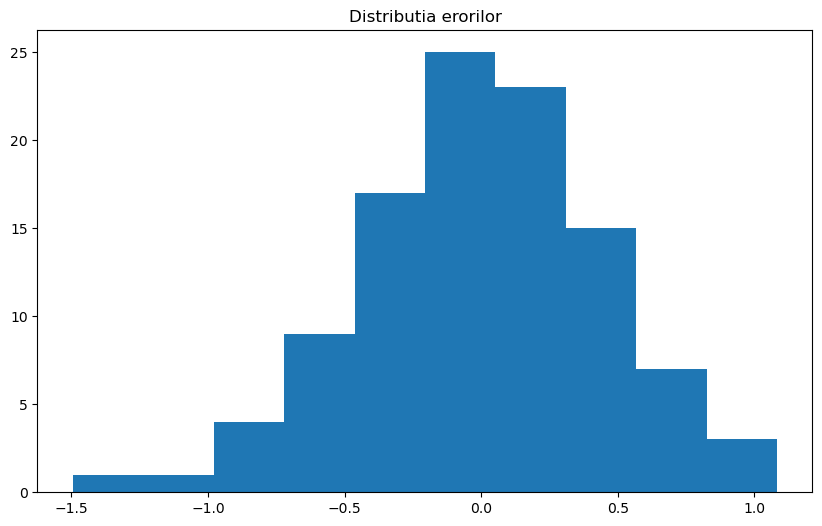

In [196]:
testare_normalitate(regresie=regresie_cook,bins=10)

Testul White
(13.970851140756443, 0.3758999931245823, 1.0743367285188492, 0.3910469998444814)
Test Breuche-Pagan
(6.9411417779926925, 0.1390314972129562, 1.7696365998566397, 0.14089015160149862)


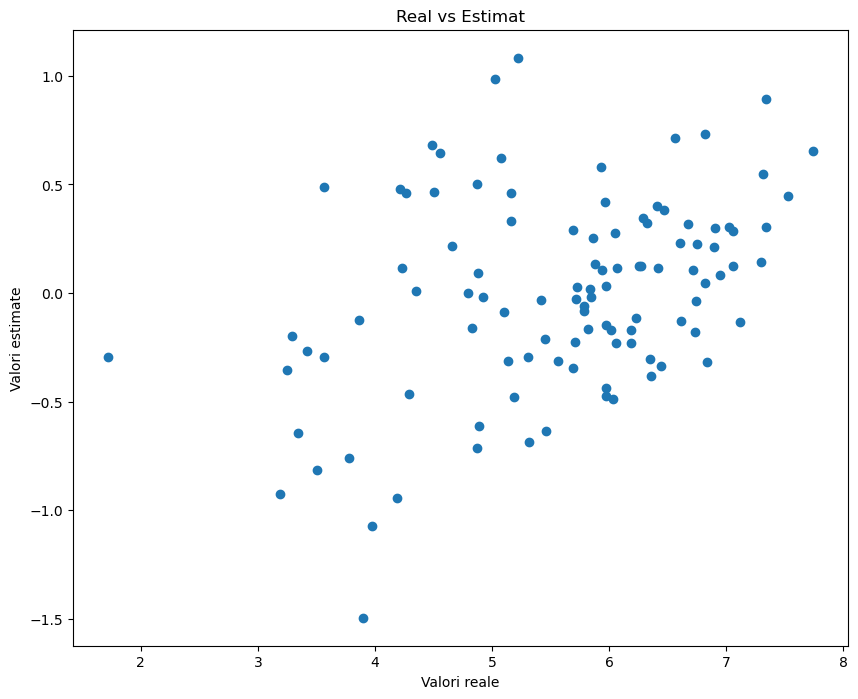

In [197]:
testare_homoschedasticitate(regression=regresie_cook,actual=df_with_cook.loc[df_with_cook.dropna().index,'happy'])

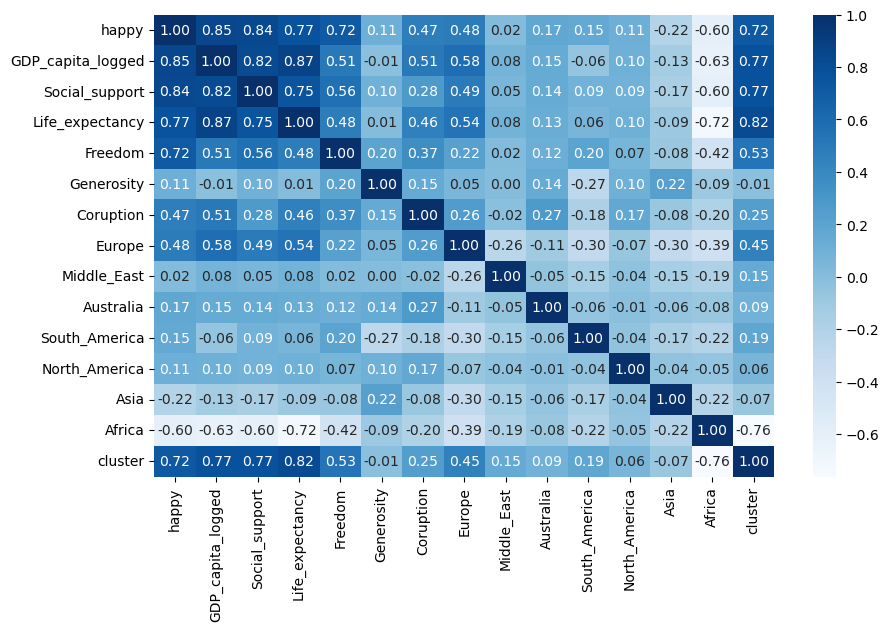

In [160]:
col = list(df_with_cook.drop(columns=["Region_2","cooks_d","upperwhisker","lowerwhisker","Dystopia + residual"],inplace=False).columns)[1:]
corel_matrix = df_with_cook[col].corr()

plt.figure(figsize=(10,6))
sns.heatmap(data=corel_matrix,fmt=".2f",cmap="Blues",annot=True)
plt.show()

In [161]:
vif = {k:variance_inflation_factor(exog,i) for k,i in zip(regresie_cook.params.index,range(len(regresie_cook.params.index)))}
vif

{'Intercept': 24.513197814644766,
 'GDP_capita_logged': 3.2302013417524176,
 'Freedom': 1.545416127967776,
 'Social_support': 3.4084947729438797,
 'South_America': 1.1091471181146255}

# Evaluare a perfomantelor modelului

In [198]:
parametrii = ['Social_support','GDP_capita_logged','Freedom','South_America']
X = df_test[parametrii]
parametrii.append('happy')
parametrii.append('Region_2')
parametrii.append('cluster')
real = df_test['happy']
rezultate_regresie = df_test[parametrii].copy()
rezultate_regresie.rename(columns={'happy':'Actual'},inplace=True)
rezultate_regresie['predicted'] = regresie_cook.predict(X)
estimat = rezultate_regresie['predicted']

In [166]:
df_test

,Region,happy,upperwhisker,lowerwhisker,GDP_capita_logged,Social_support,Life_expectancy,Freedom,Generosity,Coruption,Dystopia + residual,Region_2,Europe,Middle_East,Australia,South_America,North_America,Asia,Africa,cluster
Country name,,,,,,,,,,,,,,,,,,,,
Denmark,Western Europe,7.583,7.665,7.500,1.908,1.520,0.699,0.823,0.204,0.548,1.881,Europe,1,0,0,0,0,0,0,1
Costa Rica,Latin America and Caribbean,6.955,7.051,6.860,1.561,1.373,0.661,0.797,0.109,0.123,2.333,South_America,0,0,0,1,0,0,0,1
Belgium,Western Europe,6.894,6.961,6.827,1.868,1.440,0.690,0.729,0.170,0.311,1.686,Europe,1,0,0,0,0,0,0,1
United States,North America and ANZ,6.725,6.818,6.631,1.939,1.392,0.542,0.586,0.223,0.169,1.873,North_America,0,0,0,0,1,0,0,1
Saudi Arabia,Middle East and North Africa,6.594,6.707,6.480,1.842,1.361,0.511,0.787,0.114,0.188,1.790,Middle_East,0,1,0,0,0,0,0,1
Singapore,Southeast Asia,6.523,6.605,6.440,2.118,1.361,0.769,0.743,0.168,0.575,0.788,Asia,0,0,0,0,0,1,0,1
Taiwan Province of China,East Asia,6.503,6.597,6.410,1.842,1.346,0.650,0.649,0.068,0.202,1.747,Asia,0,0,0,0,0,1,0,1
Romania,Central and Eastern Europe,6.491,6.592,6.390,1.699,1.236,0.583,0.717,0.041,0.006,2.210,Europe,1,0,0,0,0,0,0,1
Poland,Central and Eastern Europe,6.442,6.513,6.370,1.738,1.417,0.639,0.600,0.081,0.175,1.791,Europe,1,0,0,0,0,0,0,1


Calcul RMSE, R2, MAE, MAPE, R2-Ajustat

RMSE: 0.6237606383780644
MSE: 0.3890773339898105
R-squared: 0.652224305241955
MAE: 0.42182997675342865
MAPE: 9.31%


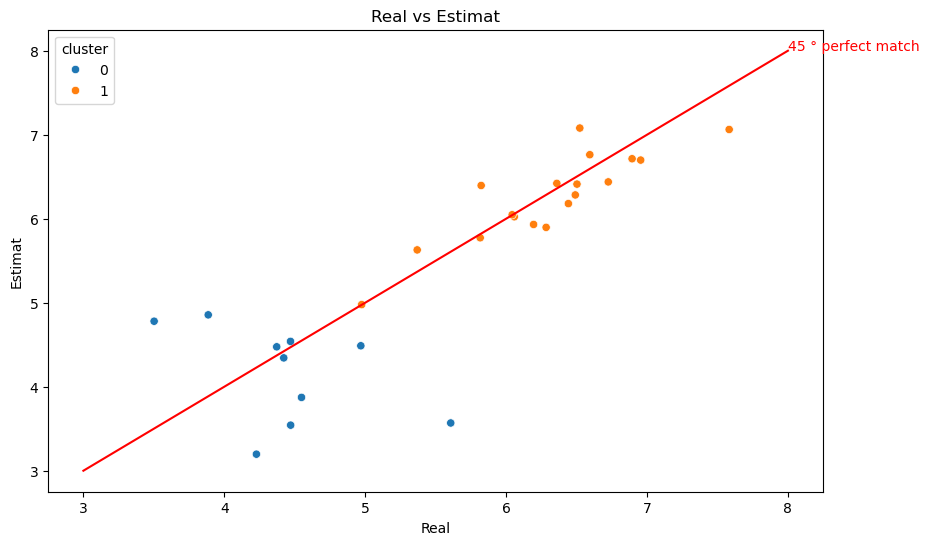

In [199]:


RMSE = np.sqrt(np.mean(np.power(real -estimat,2)))
print("RMSE: "+ str(RMSE))
MSE = np.mean(np.power(real-estimat,2))
print("MSE: "+ str(MSE))

r2_testData = r2_score(real,estimat)
print("R-squared: "+ str(r2_testData))

MAE = mean_absolute_error(real, estimat)
print("MAE: "+ str(MAE))

conditie = real != 0
# mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
mape = np.mean(np.abs(real[conditie] - estimat[conditie]) / estimat[conditie]) * 100
print("MAPE: "+ str(np.round(mape,2))+"%")


plt.figure(figsize=(10,6))
sns.scatterplot(x='Actual',y='predicted',hue='cluster',data=rezultate_regresie)
plt.xlabel("Real")
plt.ylabel("Estimat")
plt.title("Real vs Estimat")
x = np.linspace(3, 8, 100)
plt.plot(x, x,color='red')
plt.text(8,8,f"45 \N{DEGREE SIGN} perfect match",color='red')
plt.show()

In [168]:

y = df_with_cook["happy"].to_numpy()
X = df_with_cook[["GDP_capita_logged", "Social_support", "Freedom","Middle_East"]].to_numpy()
X = sm.add_constant(X)
regresie_cook = sm.OLS(y, X).fit()
reset = linear_reset(regresie_cook, power=2, use_f=True)
print(reset)

<F test: F=0.42104467784979155, p=0.5180327524660304, df_denom=92, df_num=1>


In [169]:
df_with_cook.columns

Index(['Region', 'happy', 'upperwhisker', 'lowerwhisker', 'GDP_capita_logged',
       'Social_support', 'Life_expectancy', 'Freedom', 'Generosity',
       'Coruption', 'Dystopia + residual', 'Region_2', 'Europe', 'Middle_East',
       'Australia', 'South_America', 'North_America', 'Asia', 'Africa',
       'cluster', 'cooks_d'],
      dtype='object')

In [177]:
y = df_with_cook["happy"].to_numpy()
# X = df_with_cook[["Social_support","Freedom","Asia","South_America","Life_expectancy"]].copy(deep=True)
X = df_with_cook[['GDP_capita_logged','Social_support','Freedom',"South_America"]].copy(deep=True)
# X['Freedom_2'] = np.power(X['Freedom'],2)
# X['Freedom_3'] = np.power(X['Freedom'],3)
# X['Freedom_4'] = np.power(X['Freedom'],4)
# X['Freedom_5'] = np.power(X['Freedom'],5)
# X['Freedom_6'] = np.power(X['Freedom'],6)
X = X.to_numpy()
X = sm.add_constant(X)
regresie = sm.OLS(y, X).fit()
reset = linear_reset(regresie, power=2, use_f=True)
print(regresie.summary())
print(reset)
# vif = {k:variance_inflation_factor(regresie.model.exog,i) for k,i in zip(regresie.params.index,range(len(regresie.params.index)))}
# print(vif)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     148.7
Date:                Tue, 23 Dec 2025   Prob (F-statistic):           1.59e-39
Time:                        16:15:58   Log-Likelihood:                -51.296
No. Observations:                  98   AIC:                             112.6
Df Residuals:                      93   BIC:                             125.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0209      0.210      4.869      0.0

In [84]:
df_with_cook.head()

,Region,happy,upperwhisker,lowerwhisker,GDP_capita_logged,Social_support,Life_expectancy,Freedom,Generosity,Coruption,Dystopia + residual,Region_2,Europe,Middle_East,Australia,South_America,North_America,Asia,Africa,cooks_d
Country name,,,,,,,,,,,,,,,,,,,,
Egypt,Middle East and North Africa,3.977,4.066,3.887,1.370,0.996,0.488,0.490,0.025,0.259,0.349,Africa,0,0,0,0,0,0,1,0.022067
Burkina Faso,Sub-Saharan Africa,4.548,4.686,4.410,0.756,0.685,0.274,0.483,0.173,0.179,1.999,Africa,0,0,0,0,0,0,1,0.010498
Namibia,Sub-Saharan Africa,4.832,4.958,4.705,1.266,1.212,0.307,0.470,0.069,0.061,1.446,Africa,0,0,0,0,0,0,1,0.003256
Sierra Leone,Sub-Saharan Africa,3.245,3.366,3.124,0.654,0.566,0.253,0.469,0.181,0.053,1.068,Africa,0,0,0,0,0,0,1,0.011016
Ivory Coast,Sub-Saharan Africa,5.080,5.224,4.936,1.080,0.578,0.288,0.547,0.120,0.164,2.303,Africa,0,0,0,0,0,0,1,0.026454


In [178]:
print("Teste pt NORMALITATE\n")
testare_normalitate(regresie,10,afiseaza_grafic=False)

print("\nTeste pt Homoscedasticitate\n")
testare_homoschedasticitate(regression=regresie,actual=y,afiseaza_grafic=False)

print("\nDURBIN WATSON AUTOCORELARE: "+str(durbin_watson(regresie.resid)))

Teste pt NORMALITATE

jarque_bera
(10.196645797421873, 0.006106980005899181, -0.5792050919942517, 4.074813282360764)
SHAPIRO
ShapiroResult(statistic=0.9751641750335693, pvalue=0.060100965201854706)
Kolmogov Smirnov
KstestResult(statistic=0.06659363629742554, pvalue=0.7520440430567158, statistic_location=-0.2621491213899949, statistic_sign=-1)

Teste pt Homoscedasticitate

Testul White
(10.79526142172148, 0.6279645423357039, 0.7998876897750424, 0.6584317934212642)
Test Breuche-Pagan
(2.7207886927075733, 0.6055817907879133, 0.6639259103586801, 0.6186202670276423)

DURBIN WATSON AUTOCORELARE: 1.9234232452365865


In [ ]:
print(regresie_cook.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     93.03
Date:                Tue, 23 Dec 2025   Prob (F-statistic):           6.55e-27
Time:                        00:35:36   Log-Likelihood:                -58.546
No. Observations:                  90   AIC:                             125.1
Df Residuals:                      86   BIC:                             135.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3567      0.238      9.917      0.0

Testul White
(8.562803460580353, 0.47856870006702923, 0.9346319835758237, 0.5001442026865781)
Test Breuche-Pagan
(4.962727951725382, 0.17454682032922716, 1.6729707400385438, 0.1788103037958681)


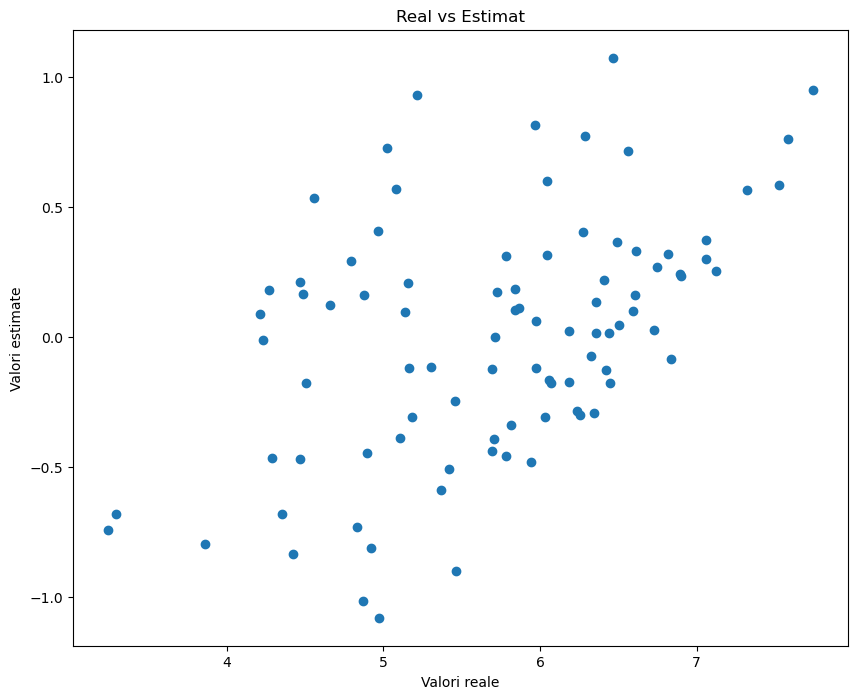

In [ ]:
testare_homoschedasticitate(regresie_cook,y)

jarque_bera
(0.41027859107137, 0.8145338475801149, -0.0848210675918007, 2.7160472393935087)
SHAPIRO
ShapiroResult(statistic=0.9899070262908936, pvalue=0.7241988182067871)
Kolmogov Smirnov
KstestResult(statistic=0.05663106544962937, pvalue=0.919211190119734, statistic_location=-0.0116669607852673, statistic_sign=-1)


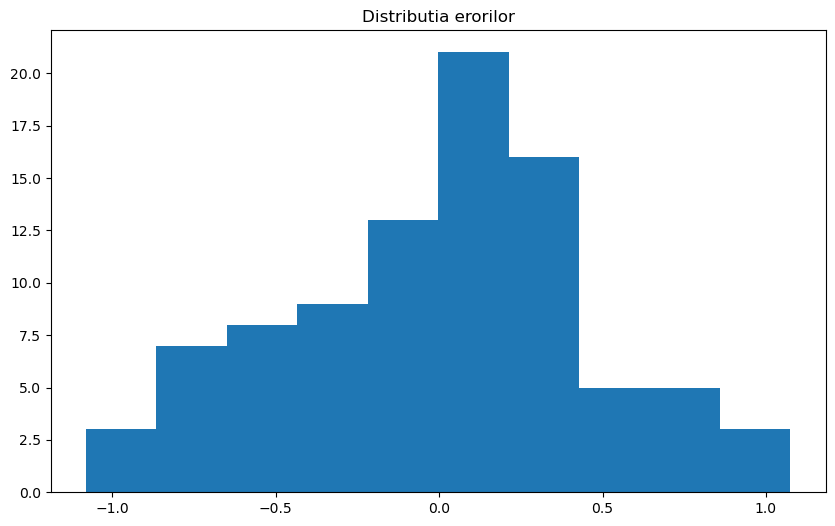

In [ ]:
testare_normalitate(regresie=regresie_cook,bins=10)

In [ ]:
df.columns

Index(['Region', 'happy', 'upperwhisker', 'lowerwhisker', 'GDP_capita_logged',
       'Social_support', 'Life_expectancy', 'Freedom', 'Generosity',
       'Coruption', 'Dystopia + residual', 'Region_2'],
      dtype='object')

In [ ]:
# pip install --upgrade statsmodels

In [ ]:
scaler = StandardScaler()
X = df_with_cook[['Social_support','GDP_capita_logged','Freedom','South_America']].to_numpy()
y = df_with_cook['happy'].to_numpy()
X_cook_scaled_train = scaler.fit_transform(X)
# y_cook_scaled_train = scaler.fit_transform(y)
y_cook_scaled_train = (y - np.mean(y))/ np.std(y)
X_scaled_test = scaler.fit_transform(df_test[['Social_support','GDP_capita_logged','Freedom','South_America']])
y_scaled_test = (df_test['happy'] - df_test['happy'].mean())/df_test['happy'].std()
r2_testData = r2_score(df_test['happy'],regresie_cook.predict(df_test[['Social_support','GDP_capita_logged','Freedom','South_America']]))

Ridge

In [272]:
ridge = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100])
ridge.fit(X_cook_scaled_train, y_cook_scaled_train)
ridge_coef = ridge.coef_
ridge_r2 = ridge.score(X_scaled_test, y_scaled_test)
print(f"Ridge R-squared {ridge_r2}")
print("Orifinal R-squared: "+ str(r2_testData))

Ridge R-squared 0.693530140515285
Orifinal R-squared: 0.6664519946049898


Lasso

In [273]:
lasso = LassoCV(
    alphas=None,
    cv=5,
    random_state=42,
    max_iter=10000
)
lasso.fit(X_cook_scaled_train, y_cook_scaled_train)

lasso_coef = lasso.coef_
lasso_r2 = lasso.score(X_scaled_test, y_scaled_test)
print(f"Lasso R-squared {lasso_r2}")
print("Original R-squared: "+ str(r2_testData))

Lasso R-squared 0.6930923317784847
Original R-squared: 0.6664519946049898


Elastic Net

In [276]:
elastic = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.9],
    alphas=None,
    cv=5,
    random_state=42,
    max_iter=10000
)
elastic.fit(X_cook_scaled_train, y_cook_scaled_train)

elastic_coef = elastic.coef_
elastic_r2 = elastic.score(X_scaled_test, y_scaled_test)
print(f"Elastic R-squared {elastic_r2}")
print("Original R-squared: "+ str(r2_testData))

Elastic R-squared 0.6931387514309023
Original R-squared: 0.6664519946049898


In [263]:
regresie_cook.params

Intercept            1.302523
GDP_capita_logged    0.965899
Freedom              1.961238
Social_support       1.499661
South_America        0.240962
dtype: float64

# To do
###
1. Spargere Train Test ✅
2. Antrenare pe Train, testare pe test ✅
3. Evaluarea RMSE, R2 pe test data ✅
4. Adaugare polinomiala
5. Adaugare termeni de regularizare

# Rezultate FINALE

In [294]:
Asia = ['Southeast Asia','East Asia','South Asia']
Europe = ['Western Europe','Central and Eastern Europe']
North_America = ['United States','Canada']
Australia = ['Australia','New Zealand']
Africa = ['Sub-Saharan Africa']
Countries_not_in_middle_east =['Ukraine','Moldova','Georgia']
African_countries = ["Libya","Algeria","Morocco","Tunisia","Egypt"]

In [295]:
df = pd.read_csv('World-happiness-report-2024.csv',index_col=0)
df.dropna(inplace=True)
df.rename(columns={
    'Log GDP per capita':'GDP_capita_logged',
    'Perceptions of corruption':'Coruption',
    'Healthy life expectancy':'Life_expectancy',
    'Social support':'Social_support',
    'Ladder score':'happy',
    'Regional indicator':'Region',
    'Freedom to make life choices':'Freedom'
},inplace=True)
df['Region_2'] = df.apply(lambda x: 'Asia' if x['Region'] in Asia else
                                              'Europe' if x['Region'] in Europe else
                                              'North_America' if x.name in North_America else
                                              'Australia' if x.name in Australia else
                                              'Africa' if x['Region'] in Africa else
                                              'South_America' if x['Region'] =='Latin America and Caribbean' else
                                              'Europe' if x['Region']=='Commonwealth of Independent States' and x.name in Countries_not_in_middle_east else
                                              'Middle_East' if x['Region']=='Commonwealth of Independent States' and x.name not in Countries_not_in_middle_east else
                                              'Africa' if x.name in African_countries else 'Middle East',axis=1)
df.loc[df['Region_2']=='Middle East','Region_2'] = 'Middle_East'
continents = df['Region_2'].drop_duplicates()
for continent in continents:
    conditie = df['Region_2'] == continent
    # print(sum(conditie))
    df[continent] = 0
    df.loc[conditie,continent] = 1

In [296]:
# variabile = ['GDP_capita_logged','Social_support', 'Life_expectancy', 'Freedom', 'Generosity','Coruption']
# X = df[variabile].values
# X_scaled = StandardScaler().fit_transform(X)
# inertias = []

# for k in range(1, 8):
#     km = KMeans(n_clusters=k, random_state=42, n_init=10)
#     km.fit(X_scaled)
#     inertias.append(km.inertia_)

# plt.figure()
# plt.plot(range(1, 8), inertias, marker='o')
# plt.xlabel("Number of clusters (k)")
# plt.ylabel("WCSS (Inertia)")
# plt.title("Elbow Method for K-means")
# plt.show()

In [309]:
variabile = ['GDP_capita_logged','Social_support', 'Life_expectancy', 'Freedom', 'Generosity','Coruption']
X = df[variabile].values
X_scaled = StandardScaler().fit_transform(X)
df['cluster'] = KMeans(n_clusters=2,random_state=42,n_init=10).fit_predict(X_scaled)
print(df['cluster'].value_counts(normalize=True))
df_train = df.groupby('Region_2').sample(frac=0.8)
index_train = df_train.index
conditie = ~df.index.isin(index_train)
df_test = df[conditie].copy()
print(len(df_test['Region_2'].value_counts(normalize=True)))
print(len(df_train['Region_2'].value_counts(normalize=True)))

d:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


cluster
1    0.635714
0    0.364286
Name: proportion, dtype: float64
5
7


In [347]:
regresie = smf.ols('happy ~ GDP_capita_logged +Freedom + I(Social_support**3) + South_America',data=df_train).fit()
print(regresie.summary()) 
exog = regresie.model.exog
fit = regresie.fittedvalues

                            OLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     128.3
Date:                Tue, 23 Dec 2025   Prob (F-statistic):           4.31e-40
Time:                        18:11:22   Log-Likelihood:                -78.849
No. Observations:                 113   AIC:                             167.7
Df Residuals:                     108   BIC:                             181.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2

Testul White
(25.42737033477886, 0.020271558469708784, 2.2111840833993432, 0.014139730287852974)
Test Breuche-Pagan
(17.146593645085687, 0.0018101977584882314, 4.8298547336244795, 0.0012707901050807012)


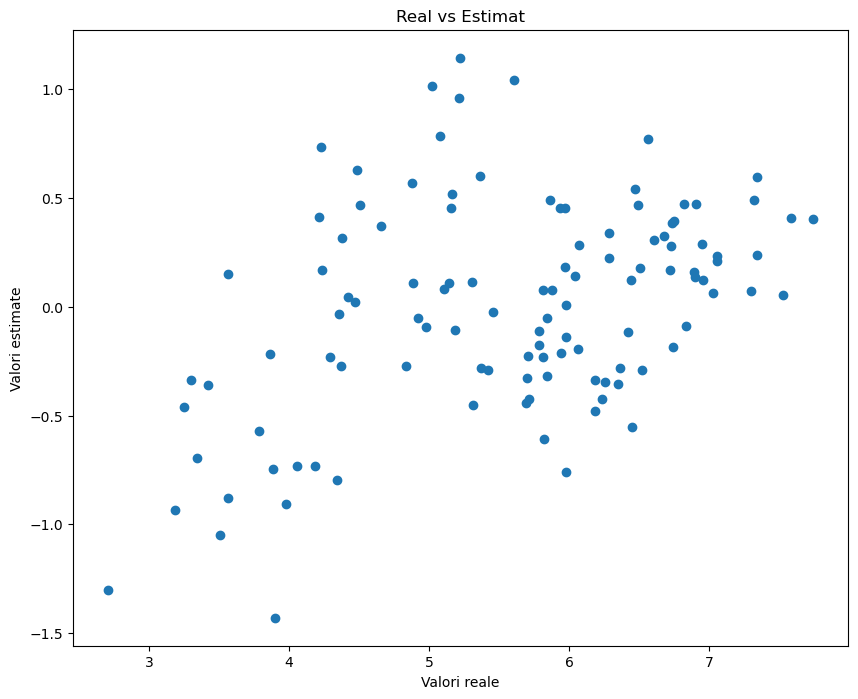

In [348]:
testare_homoschedasticitate(regression=regresie,actual=df_train['happy'])

jarque_bera
(1.8562104383254048, 0.39530201189110875, -0.30241524815405935, 3.168580710245076)
SHAPIRO
ShapiroResult(statistic=0.9893692135810852, pvalue=0.5249112248420715)
Kolmogov Smirnov
KstestResult(statistic=0.05843117042923446, pvalue=0.8133967486598495, statistic_location=0.04450610578581493, statistic_sign=-1)


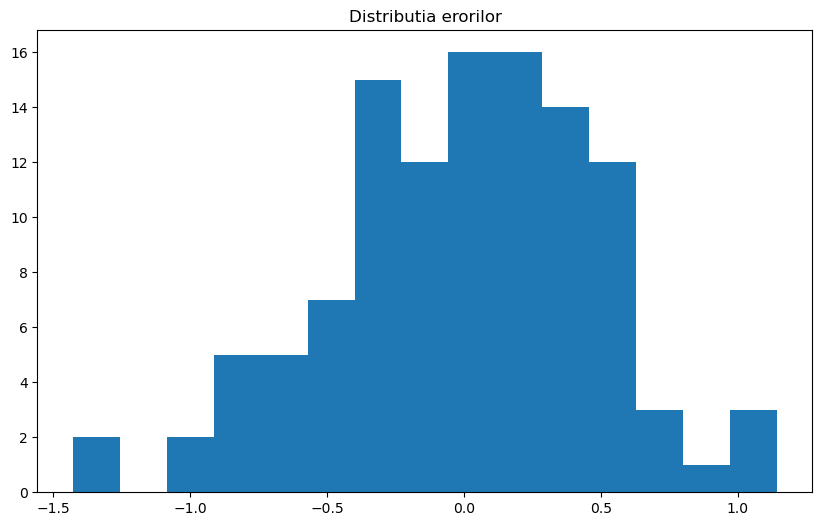

In [349]:
testare_normalitate(regresie=regresie,bins=15)

In [327]:
# weigths = 1 / (np.power(fit,2))
# wls = sm.WLS(df_train.loc[df_train.dropna().index,'happy'],exog=exog,weights=weigths).fit()
# print(wls.summary())

In [328]:
# testare_homoschedasticitate(regression=wls,actual=df_train['happy'])

In [329]:
# testare_normalitate(regresie=wls,bins=15)

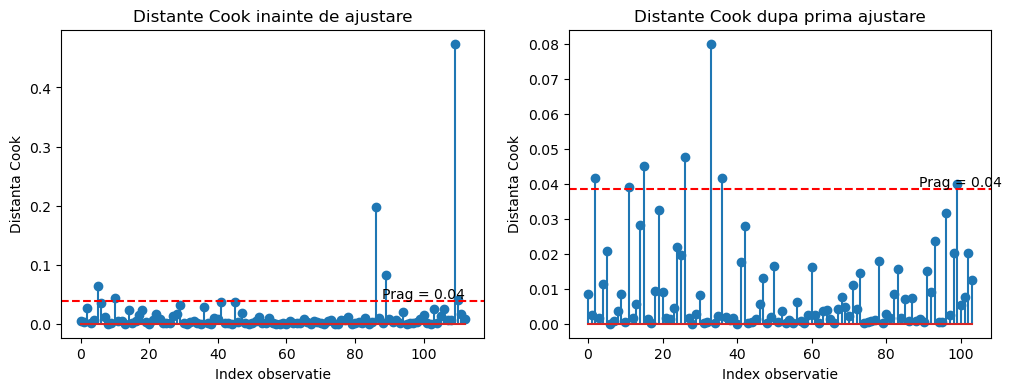

jarque_bera
(6.77634781324683, 0.03377028832818213, -0.3760699550862324, 3.9990285920900797)
SHAPIRO
ShapiroResult(statistic=0.9831183552742004, pvalue=0.20866619050502777)
Kolmogov Smirnov
KstestResult(statistic=0.06597693333453947, pvalue=0.7305092634060616, statistic_location=-0.2965533131737228, statistic_sign=-1)


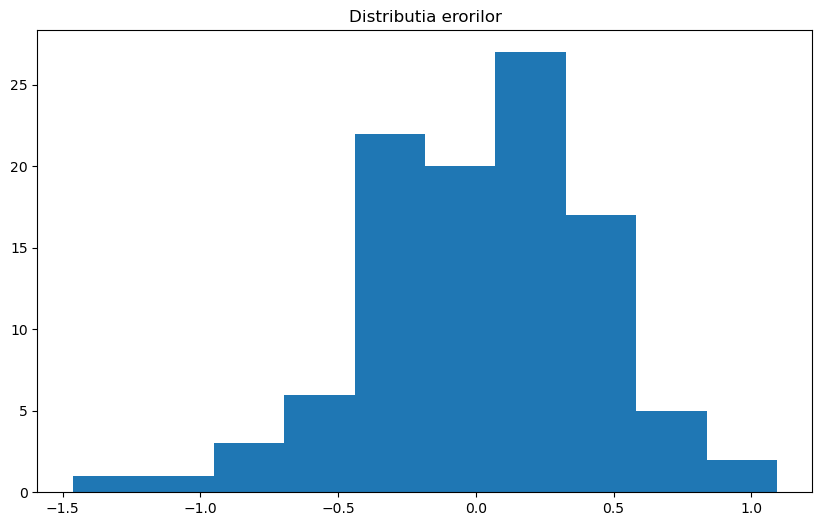

In [351]:
influence = regresie.get_influence()
cooks_d, p_values = influence.cooks_distance
df_with_cook = df_train.copy()
df_with_cook['cooks_d'] = cooks_d
influential = df_with_cook[df_with_cook['cooks_d'] > 4 / len(df_with_cook)]
df_with_cook.drop(index=influential.index,inplace=True)

figura, axe = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax1,ax2 = axe

ax1.stem(cooks_d)
ax1.set_xlabel('Index observatie')
ax1.set_ylabel("Distanta Cook")
ax1.set_title("Distante Cook inainte de ajustare")
ax1.axhline(4 / len(df_with_cook),linestyle="--",color='red')
ax1.text(100,
         4 / len(df_with_cook),
        f"Prag = {np.round(4 / len(df_with_cook),2)}",
        va="bottom",
        ha="center"
        )
regresie_cook = smf.ols('happy ~ GDP_capita_logged +Freedom + I(Social_support**3) + South_America',data=df_with_cook).fit()
# exog = regresie_cook.model.exog
# fit = regresie_cook.fittedvalues


influence = regresie_cook.get_influence()
cooks_d, p_values = influence.cooks_distance
# df_with_cook = df.copy()
df_with_cook['cooks_d'] = cooks_d
influential = df_with_cook[df_with_cook['cooks_d'] > 4 / len(df_with_cook)]
# df_with_cook.drop(index=influential.index,inplace=True)
ax2.stem(cooks_d)
ax2.set_xlabel('Index observatie')
ax2.set_ylabel("Distanta Cook")
ax2.set_title("Distante Cook dupa prima ajustare")
ax2.axhline(4 / len(df_with_cook),linestyle="--",color="red")
ax2.text(100,
         4 / len(df_with_cook),
        f"Prag = {np.round(4 / len(df_with_cook),2)}",
        va="bottom",
        ha="center"
        )

plt.show()

testare_normalitate(regresie=regresie_cook,bins=10)

In [364]:
testare_homoschedasticitate(regression=regresie_cook,actual=df_with_cook['happy'],afiseaza_grafic=False)

Testul White
(12.071884043502887, 0.5217583527440779, 0.9091297147782856, 0.5468112345770644)
Test Breuche-Pagan
(7.974151334329942, 0.09252966641955039, 2.055282491819557, 0.0924458044374068)


In [365]:
testare_normalitate(regresie=regresie_cook,bins=15,afiseaza_grafic=False)

jarque_bera
(6.77634781324683, 0.03377028832818213, -0.3760699550862324, 3.9990285920900797)
SHAPIRO
ShapiroResult(statistic=0.9831183552742004, pvalue=0.20866619050502777)
Kolmogov Smirnov
KstestResult(statistic=0.06597693333453947, pvalue=0.7305092634060616, statistic_location=-0.2965533131737228, statistic_sign=-1)


In [367]:
print("\nDURBIN WATSON AUTOCORELARE: "+str(durbin_watson(regresie_cook.resid)))


DURBIN WATSON AUTOCORELARE: 1.9370745925143213


In [366]:
vif = {k:variance_inflation_factor(exog,i) for k,i in zip(regresie_cook.params.index,range(len(regresie_cook.params.index)))}
vif

{'Intercept': 23.729135512613297,
 'GDP_capita_logged': 2.308470809184135,
 'Freedom': 1.3291523859587655,
 'I(Social_support ** 3)': 2.36293416606102,
 'South_America': 1.1126670508677028}

In [355]:
regresie_cook = smf.ols('happy ~ GDP_capita_logged +Freedom + I(Social_support**3) + South_America',data=df_with_cook).fit()
reset = linear_reset(regresie_cook, power=2, use_f=True)
print(regresie_cook.summary())
print(reset)

                            OLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     153.5
Date:                Tue, 23 Dec 2025   Prob (F-statistic):           1.59e-41
Time:                        18:13:01   Log-Likelihood:                -56.367
No. Observations:                 104   AIC:                             122.7
Df Residuals:                      99   BIC:                             136.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

In [356]:
# X = df_with_cook[["Social_support","Freedom","Asia","South_America","Life_expectancy"]].copy(deep=True)
# X['Freedom_2'] = np.power(X['Freedom'],2)
# X['Freedom_3'] = np.power(X['Freedom'],3)
# X['Freedom_4'] = np.power(X['Freedom'],4)
# X['Freedom_5'] = np.power(X['Freedom'],5)
# X['Freedom_6'] = np.power(X['Freedom'],6)


In [358]:
scaler = StandardScaler()
X = df_with_cook[['Social_support','GDP_capita_logged','Freedom','South_America']].copy()
X['Freedom'] = X['Freedom']**3
X =X.to_numpy()
y = df_with_cook['happy'].to_numpy()
X_cook_scaled_train = scaler.fit_transform(X)
# y_cook_scaled_train = scaler.fit_transform(y)
y_cook_scaled_train = (y - np.mean(y))/ np.std(y)
X_scaled_test = scaler.fit_transform(df_test[['Social_support','GDP_capita_logged','Freedom','South_America']])
y_scaled_test = (df_test['happy'] - df_test['happy'].mean())/df_test['happy'].std()
r2_testData = r2_score(df_test['happy'],regresie_cook.predict(df_test[['Social_support','GDP_capita_logged','Freedom','South_America']]))

Ridge

In [359]:
ridge = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100])
ridge.fit(X_cook_scaled_train, y_cook_scaled_train)
ridge_coef = ridge.coef_
ridge_r2 = ridge.score(X_scaled_test, y_scaled_test)
print(f"Ridge R-squared {ridge_r2}")
print("Orifinal R-squared: "+ str(r2_testData))

Ridge R-squared 0.7658121301335952
Orifinal R-squared: 0.7407152613965359


Lasso

In [360]:
lasso = LassoCV(
    alphas=None,
    cv=5,
    random_state=42,
    max_iter=10000
)
lasso.fit(X_cook_scaled_train, y_cook_scaled_train)

lasso_coef = lasso.coef_
lasso_r2 = lasso.score(X_scaled_test, y_scaled_test)
print(f"Lasso R-squared {lasso_r2}")
print("Original R-squared: "+ str(r2_testData))

Lasso R-squared 0.7678541047267121
Original R-squared: 0.7407152613965359


Elastic Net

In [361]:
elastic = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.9],
    alphas=None,
    cv=5,
    random_state=42,
    max_iter=10000
)
elastic.fit(X_cook_scaled_train, y_cook_scaled_train)

elastic_coef = elastic.coef_
elastic_r2 = elastic.score(X_scaled_test, y_scaled_test)
print(f"Elastic R-squared {elastic_r2}")
print("Original R-squared: "+ str(r2_testData))

Elastic R-squared 0.7774927325403465
Original R-squared: 0.7407152613965359


In [362]:
parametrii = ['Social_support','GDP_capita_logged','Freedom','South_America']
X = df_test[parametrii].copy()
X['Freedom'] = X['Freedom']**3
parametrii.append('happy')
parametrii.append('Region_2')
parametrii.append('cluster')
real = df_test['happy']
rezultate_regresie = df_test[parametrii].copy()
rezultate_regresie.rename(columns={'happy':'Actual'},inplace=True)
rezultate_regresie['predicted'] = regresie_cook.predict(X)
estimat = rezultate_regresie['predicted']

RMSE: 0.7953763653534272
MSE: 0.6326235625628284
R-squared: 0.5698074874280565
MAE: 0.6753071633019387
MAPE: 16.46%


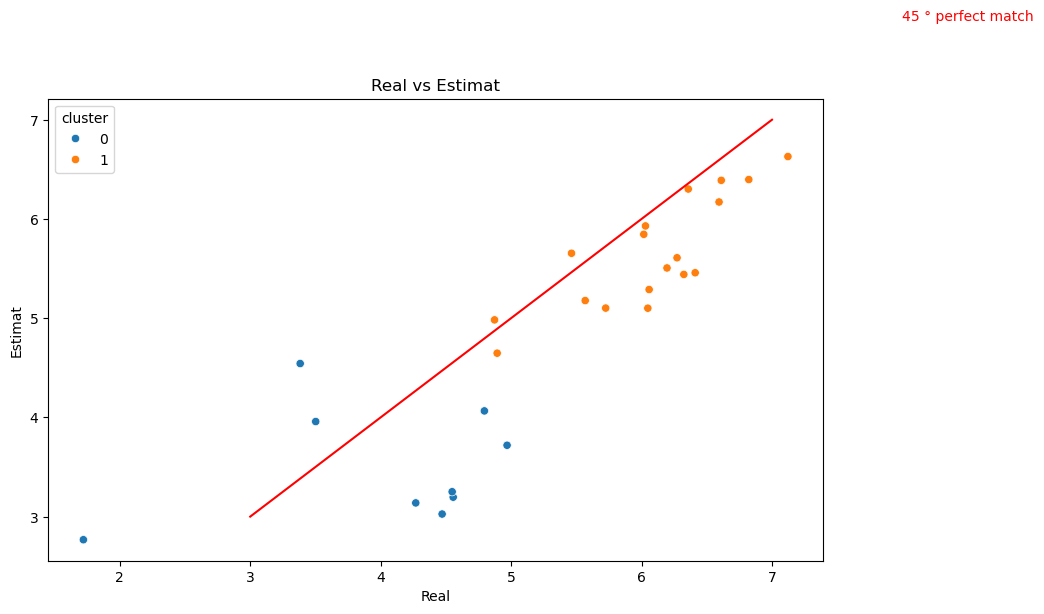

In [368]:
RMSE = np.sqrt(np.mean(np.power(real -estimat,2)))
print("RMSE: "+ str(RMSE))
MSE = np.mean(np.power(real-estimat,2))
print("MSE: "+ str(MSE))

r2_testData = r2_score(real,estimat)
print("R-squared: "+ str(r2_testData))

MAE = mean_absolute_error(real, estimat)
print("MAE: "+ str(MAE))

conditie = real != 0
# mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
mape = np.mean(np.abs(real[conditie] - estimat[conditie]) / estimat[conditie]) * 100
print("MAPE: "+ str(np.round(mape,2))+"%")


plt.figure(figsize=(10,6))
sns.scatterplot(x='Actual',y='predicted',hue='cluster',data=rezultate_regresie)
plt.xlabel("Real")
plt.ylabel("Estimat")
plt.title("Real vs Estimat")
x = np.linspace(3, 7, 100)
plt.plot(x, x,color='red')
plt.text(8,8,f"45 \N{DEGREE SIGN} perfect match",color='red')
plt.show()